In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import holidays


In [ ]:
df_cleaned=pd.read_csv("/content/drive/MyDrive/Research_s3/Dataset/data_cleaned (1).csv")

<ipython-input-3-d2bfad8ec787>:1: DtypeWarning: Columns (14,16,17,18,19,20,21,23,25,27,50,51,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned=pd.read_csv("/content/drive/MyDrive/Research_s3/Dataset/data_cleaned (1).csv")


In [ ]:

df_cleaned=df_cleaned.dropna(axis=1, how='all')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

# Define models dictionary
models = {
    "random_forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "xgboost": XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=200, learning_rate=0.1, max_depth=5),
    "light_gbm": LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
}

# Extract all columns containing drug and dosage
drug_columns = [f'drug_{i}' for i in range(1, 10)]
dosage_columns = [f'dosage_{i}' for i in range(1, 10)]

# Filter rows where any drug column contains "Chlorpheniramine maleate 4mg tab"
paracetamol_data = df_cleaned[
    df_cleaned[drug_columns].apply(lambda x: x.str.contains("Paracetamol 500mg tab", na=False)).any(axis=1)
]

# Aggregate by date
paracetamol_data['date'] = pd.to_datetime(paracetamol_data['date'])
time_series = paracetamol_data.groupby('date').size().reset_index(name='prescription_count')

# Create temporal features
time_series['month'] = time_series['date'].dt.month
time_series['day_of_week'] = time_series['date'].dt.dayofweek
time_series['year'] = time_series['date'].dt.year
time_series['is_weekend'] = time_series['day_of_week'].isin([5, 6]).astype(int)

# Add holiday indicator
india_holidays = holidays.India(years=range(time_series['year'].min(), time_series['year'].max() + 1))
time_series['is_holiday'] = time_series['date'].isin(india_holidays).astype(int)

# Add lag features and rolling averages
for lag in range(1, 8):
    time_series[f'prescription_count_lag_{lag}'] = time_series['prescription_count'].shift(lag)
time_series['rolling_mean_3'] = time_series['prescription_count'].rolling(window=3).mean()
time_series['rolling_mean_7'] = time_series['prescription_count'].rolling(window=7).mean()

# Drop rows with NaN values
time_series = time_series.dropna()

# Define features and target
features = ['month', 'day_of_week', 'year', 'is_weekend', 'is_holiday'] + \
           [f'prescription_count_lag_{i}' for i in range(1, 8)] + \
           ['rolling_mean_3', 'rolling_mean_7']
X = time_series[features]
y = time_series['prescription_count']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, shuffle=False)

# Train and evaluate each model
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results[name] = {
        "train_mse": mean_squared_error(y_train, y_pred_train),
        "train_mae": mean_absolute_error(y_train, y_pred_train),
        "train_r2": r2_score(y_train, y_pred_train),
        "test_mse": mean_squared_error(y_test, y_pred_test),
        "test_mae": mean_absolute_error(y_test, y_pred_test),
        "test_r2": r2_score(y_test, y_pred_test)
    }

# LSTM model
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], 1)),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train, epochs=20, verbose=0, batch_size=32)

y_pred_train_lstm = lstm_model.predict(X_train_lstm).flatten()
y_pred_test_lstm = lstm_model.predict(X_test_lstm).flatten()

results["lstm"] = {
    "train_mse": mean_squared_error(y_train, y_pred_train_lstm),
    "train_mae": mean_absolute_error(y_train, y_pred_train_lstm),
    "train_r2": r2_score(y_train, y_pred_train_lstm),
    "test_mse": mean_squared_error(y_test, y_pred_test_lstm),
    "test_mae": mean_absolute_error(y_test, y_pred_test_lstm),
    "test_r2": r2_score(y_test, y_pred_test_lstm)
}

# Print results
for model, metrics in results.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()


<ipython-input-4-fcfd2c35284b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paracetamol_data['date'] = pd.to_datetime(paracetamol_data['date'])
<ipython-input-4-fcfd2c35284b>:29: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  time_series['is_holiday'] = time_series['date'].isin(india_holidays).astype(int)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sk

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 612, number of used features: 14
[LightGBM] [Info] Start training from score 293.740196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grids
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

lgbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [20, 31, 40],
    'subsample': [0.8, 1]
}

# Hyperparameter tuning for XGBoost
xgb_grid_search = GridSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_
print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")

# Hyperparameter tuning for LightGBM
lgbm_grid_search = GridSearchCV(
    LGBMRegressor(random_state=42),
    param_grid=lgbm_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)
lgbm_grid_search.fit(X_train, y_train)
best_lgbm_model = lgbm_grid_search.best_estimator_
print(f"Best LightGBM parameters: {lgbm_grid_search.best_params_}")

# Evaluate tuned models
tuned_models = {
    "xgboost_tuned": best_xgb_model,
    "light_gbm_tuned": best_lgbm_model
}

for name, model in tuned_models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    results[name] = {
        "train_mse": mean_squared_error(y_train, y_pred_train),
        "train_mae": mean_absolute_error(y_train, y_pred_train),
        "train_r2": r2_score(y_train, y_pred_train),
        "test_mse": mean_squared_error(y_test, y_pred_test),
        "test_mae": mean_absolute_error(y_test, y_pred_test),
        "test_r2": r2_score(y_test, y_pred_test)
    }

# Print results
for model, metrics in results.items():
    print(f"Model: {model}")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}")
    print()


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best XGBoost parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1808
[LightGBM] [Info] Number of data points in the train set: 612, number of used features: 14
[LightGBM] [Info] Start training from score 293.740196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


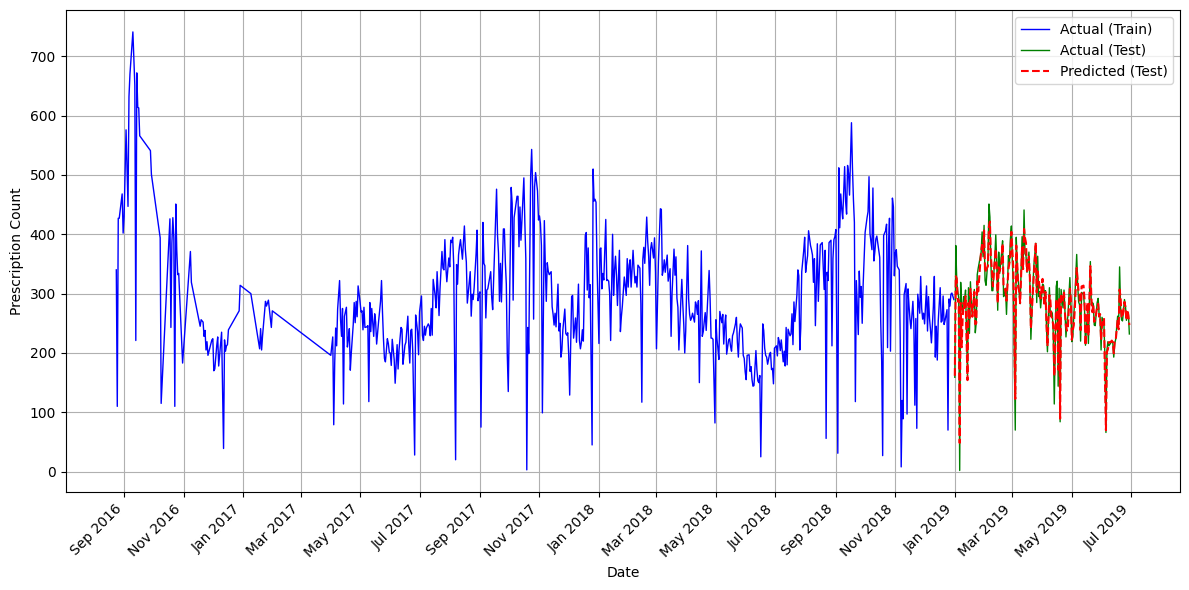

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Plot function
def plot_predictions(model_name, actual_train, actual_test, pred_test, train_dates, test_dates):
    plt.figure(figsize=(12, 6))

    # Plot actual training data
    plt.plot(train_dates, actual_train, label='Actual (Train)', color='blue', linewidth=1)

    # Plot actual test data
    plt.plot(test_dates, actual_test, label='Actual (Test)', color='green', linewidth=1)

    # Plot predicted test data
    plt.plot(test_dates, pred_test, label='Predicted (Test)', color='red', linestyle='dashed', linewidth=1.5)

    # Title and labels

    plt.xlabel('Date')
    plt.ylabel('Prescription Count')

    # Adjust x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45, ha="right")

    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Save and show plot
    plt.savefig(f'prescription_counts_(0){model_name.lower()}.png', dpi=300)
    plt.show()

# Extract train and test dates
train_dates = time_series.iloc[:len(y_train)]['date']
test_dates = time_series.iloc[len(y_train):]['date']

# XGBoost predictions
y_test_pred_xgb = best_xgb_model.predict(X_test)
plot_predictions("XGBoost", y_train, y_test, y_test_pred_xgb, train_dates, test_dates)




In [ ]:
from math import sqrt

# Print only R² and RMSE
for model, metrics in results.items():
    print(f"Model: {model}")
    print(f"  Train R²: {metrics['train_r2']:.4f}")
    print(f"  Train RMSE: {sqrt(metrics['train_mse']):.4f}")
    print(f"  Test R²: {metrics['test_r2']:.4f}")
    print(f"  Test RMSE: {sqrt(metrics['test_mse']):.4f}")
    print()

Model: random_forest
  Train R²: 0.9778
  Train RMSE: 15.5504
  Test R²: 0.8531
  Test RMSE: 27.1559

Model: xgboost
  Train R²: 0.9997
  Train RMSE: 1.8296
  Test R²: 0.9170
  Test RMSE: 20.4205

Model: light_gbm
  Train R²: 0.9742
  Train RMSE: 16.7534
  Test R²: 0.9243
  Test RMSE: 19.4953

Model: lstm
  Train R²: 0.3594
  Train RMSE: 83.5442
  Test R²: 0.2376
  Test RMSE: 61.8757

Model: xgboost_tuned
  Train R²: 0.9963
  Train RMSE: 6.3646
  Test R²: 0.9349
  Test RMSE: 18.0818

Model: light_gbm_tuned
  Train R²: 0.9616
  Train RMSE: 20.4650
  Test R²: 0.9067
  Test RMSE: 21.6454

